In [ ]:
import sys

# Install all dependencies to execute the notebook
!{sys.executable} -m pip install biopython scikit-learn pandas numpy matplotlib seaborn

In [21]:
from Bio import SeqIO
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from functions import codon_table, split_sequence

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

### Functions 

- `get_features`:  Extracts `length`, `gc_content`and `codon usage`

In [22]:
def get_features(record):
    """Extracts features from a DNA sequence"""
    
    sequence = str(record.seq)
    splitted = split_sequence(sequence)
    
    gc_content = ( sequence.count('G') + sequence.count('C') ) / len(sequence)
    length = len(sequence)
    
    data = { 'gc': gc_content, 'length': length }
    
    for key in codon_table:
        # Get codon usage per triplet
        data[key] = splitted.count(key) / len(splitted)
        
    return data

### Data handling and preparation

- Load sequences from a FASTA file
- Create inetger labels for the model training
- Extract features of each sequence and store it in a `DataFrame`

In [23]:
# Load sequences and get labels
dataset = list(SeqIO.parse( open("all_sequences.fasta"), 'fasta' ))

# Extract the organism names and turn them into integer targets
# for the ML model. Also keep a dictionary to map everything back
# to readable strings

labels = [rec.description.split('_')[0] for rec in dataset ]
mapping = {
    organism: target_int
    for target_int, organism in enumerate(list(set(labels)))
}

# Obtain integer targets
targets = [mapping[organism] for organism in labels ]

In [24]:
# Extract features of each sequence
features = [get_features(record) for record in dataset]
df = pd.DataFrame(features)

# Save data to CSV for another usage
df.to_csv('cluster_data.csv', index=False)
df.head(5)

,gc,length,TTT,TTC,TTA,TTG,TCT,TCC,TCA,TCG,...,GAA,GAG,GGT,GGC,GGA,GGG,TGG,TAA,TAG,TGA
0,0.536410,975,0.027692,0.027692,0.003077,0.006154,0.015385,0.018462,0.000000,0.027692,...,0.030769,0.009231,0.033846,0.015385,0.009231,0.009231,0.012308,0.003077,0.0,0.000000
1,0.433712,528,0.022727,0.000000,0.017045,0.000000,0.000000,0.011364,0.028409,0.000000,...,0.079545,0.022727,0.005682,0.005682,0.011364,0.005682,0.034091,0.005682,0.0,0.000000
2,0.508621,696,0.012931,0.004310,0.021552,0.017241,0.004310,0.008621,0.008621,0.004310,...,0.056034,0.008621,0.021552,0.021552,0.004310,0.017241,0.008621,0.000000,0.0,0.004310
3,0.512046,2283,0.005256,0.034166,0.001314,0.000000,0.026281,0.015769,0.000000,0.001314,...,0.055191,0.007884,0.049934,0.023653,0.001314,0.000000,0.009198,0.001314,0.0,0.000000
4,0.592357,471,0.006369,0.031847,0.000000,0.000000,0.006369,0.019108,0.025478,0.000000,...,0.025478,0.006369,0.044586,0.057325,0.012739,0.012739,0.019108,0.000000,0.0,0.006369


In [25]:
# Rescale data using MinMax Scaler
scaler = MinMaxScaler()
x = scaler.fit_transform(df.values)

### Visualisation 

- Perform a Principle Component Analysis to reduce dimensionality to two dimensions
- Visualize the dataset using `seaborn` to determine if data can be separated

*Further information:*

[Explore Matplotlib](https://matplotlib.org/)

[Explore Seaborn](https://seaborn.pydata.org/)

[Visualising high-dimensional data](https://scikit-learn.org/stable/modules/unsupervised_reduction.html)

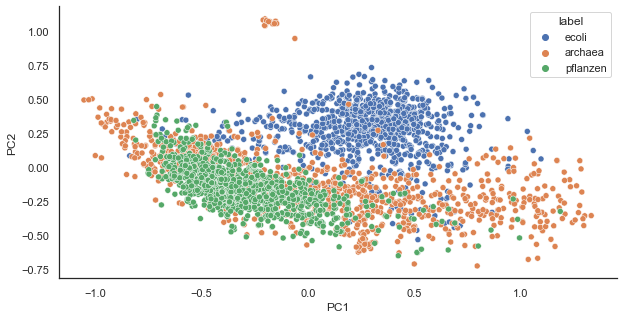

In [26]:
# Perform Principle Component Analysis
pca = PCA(n_components=2).fit_transform(x)

# Generate Plot Dataframe
df_plot = pd.DataFrame( { 'PC1': pca[:,0], 'PC2': pca[:,1], 'label': labels } )

# Plot results
plt.figure( figsize=(10,5) )
sns.scatterplot( x='PC1', y='PC2', hue='label', data=df_plot )
sns.despine()

### Training and testing

- Split the dataset into a `train` and `test`set.
- Train the `GradientBoostingClassifier` on the `train` set.
- Evaluate performance on various scores (`Accuracy`, `F1-Score`, ...)
- Plot a `confusion_matrix` to inspect possible weak spots.

*Further information:*

[Splitting datasets to Train and Test](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/)

[Information on gradient boosting](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

In [27]:
# split dataset to train and test
x_train, x_test, y_train, y_test = train_test_split(
    x, targets, test_size=0.2,
    stratify=targets, random_state=42
)

In [28]:
gc = GradientBoostingClassifier(n_estimators=700, verbose=1, random_state=42)
gc.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.0022           52.32s
         2           0.9218           51.03s
         3           0.8552           50.24s
         4           0.7998           49.92s
         5           0.7517           49.59s
         6           0.7108           49.44s
         7           0.6750           49.32s
         8           0.6412           49.19s
         9           0.6116           49.01s
        10           0.5844           48.90s
        20           0.4092           48.12s
        30           0.3145           47.20s
        40           0.2535           46.82s
        50           0.2111           46.13s
        60           0.1801           45.45s
        70           0.1550           44.77s
        80           0.1350           44.07s
        90           0.1185           43.31s
       100           0.1051           42.56s
       200           0.0377           35.34s
       300           0.0157           28.30s
       40

GradientBoostingClassifier(n_estimators=700, random_state=42, verbose=1)

In [29]:
# target names correspond to 0:plants | 1: archaea | 2: ecoli
print(classification_report(
    y_test, gc.predict(x_test),
    target_names = [ 'plants', 'archaea', 'ecoli' ]
))

              precision    recall  f1-score   support

      plants       0.98      0.95      0.97       200
     archaea       0.90      0.97      0.93       200
       ecoli       0.93      0.88      0.90       200

    accuracy                           0.94       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.94      0.93       600



<AxesSubplot:>

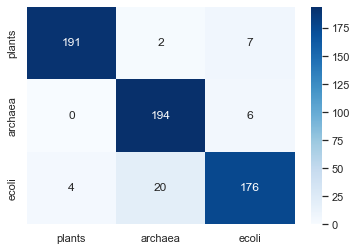

In [30]:
# Get a confusion matrix to spot weak points
cm = confusion_matrix(y_test, gc.predict(x_test))

df_cm = pd.DataFrame(cm, index = [ 'plants', 'archaea', 'ecoli' ],
                  columns = [ 'plants', 'archaea', 'ecoli' ])

sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')